VAISHALI AGARWAL, MDS202250

### Import required libraries

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, auc

import mlflow
from mlflow.tracking import MlflowClient
from mlflow.store.artifact.runs_artifact_repo import RunsArtifactRepository
from urllib.parse import urlparse

import warnings
warnings.simplefilter("ignore")

### Loading the dataset

In [52]:
train = pd.read_csv("./data/prepared/train.csv")
val = pd.read_csv("./data/prepared/validation.csv")
test = pd.read_csv("./data/prepared/test.csv")

X_train, y_train = train.text, train.spam
X_val, y_val = val.text, val.spam
X_test, y_test = test.text, test.spam

### Model Building and Tracking

In [55]:
def display_confusion_matrix(y_val, y_pred):
    """Displays the confusion matrix"""

    target_labels = ["Not Spam", "Spam"]
    cm = confusion_matrix(y_val, y_pred, normalize = "true")
    display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_labels)
    _, ax = plt.subplots(figsize = (5, 3))
    display_cm.plot(ax = ax, cmap = "Blues")
    

def evaluation(y_test, prediction):
    """Compute the evaluation metrics"""

    precision, recall, _ = precision_recall_curve(y_test, prediction)
    auc_score = auc(recall, precision)
    class_report = classification_report(y_test, prediction)
    display_confusion_matrix(y_test, prediction)
    return auc_score, class_report


In [56]:
## three benchmark models obtained from the Assignment 1 and their hyperparameters
benchmark_models = {
    "Logistic Regression": {
        "model" : LogisticRegression,
        "params" : {
            "random_state" : 64,
        }
    },
    "Random Forest Classifier": {
        "model" : RandomForestClassifier,
        "params" : {
            "min_samples_split" : 60,
            "criterion" : "log_loss",
            "class_weight" : "balanced",
            "random_state" : 64
        }
    },
    "Support Vector Classifier": {
        "model" : SVC,
        "params" : {
            "kernel" : "sigmoid",
            "random_state" : 64
        }
    }
}

In [57]:
def model_tracking(model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    """ Trains the model, and runs and tracks it in MLFlow"""
    
    print("Training {} model".format(model_name))

    vectorizer = TfidfVectorizer()

    X_train = vectorizer.fit_transform(X_train)
    X_val = vectorizer.transform(X_val)

    ## get the model configurations: model and its hyperparameters, from the benchmark_models dictionary
    model_config = benchmark_models.get(model_name)
    model_params = model_config["params"]
    model = model_config["model"](**model_params)
    
    ## fit the model
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)

    print("Training Score: {}".format(train_score))
    print("Validation Score: {}".format(val_score))

    ## get the predictions on the test dataset
    X_test = vectorizer.transform(X_test)
    prediction = model.predict(X_test)

    ## calculate AUCPR score and classification report on test dataset
    auc_score, class_report = evaluation(y_test, prediction)

    ## set the tracking uri for MLFlow
    mlflow.set_tracking_uri(uri = "http://127.0.0.1:8080")
    ## run MLFlow
    with mlflow.start_run(run_name = model_name):
        print("Running: {}".format(model_name))

        ## log hyperparameters
        mlflow.log_params(model_params)

        ## log the loss metrics
        mlflow.log_metric("AUC score", auc_score)
            
        print("Score on test set:")
        print("AUCPR score: {}".format(auc_score))
        print("Classification Report:\n {}".format(class_report))

        ## log the model
        client = MlflowClient()
        mlflow.sklearn.log_model(model, model_name)

        desc = f"A new version of {model_name} model."
        runs_id = mlflow.active_run().info.run_id
        runs_uri = f"runs:/{runs_id}/sklearn-model"
        model_src = RunsArtifactRepository.get_underlying_uri(runs_uri)

        try:
            client.create_registered_model(model_name)
        except Exception as e:
            print("{} model already registered.".format(model_name))
            
        mv = client.create_model_version(model_name, model_src, runs_id, description = desc)
        print(mv.description)
        

    

Training Logistic Regression model
Training Score: 0.9960715844609341
Validation Score: 0.9876543209876543
Running: Logistic Regression
Score on test set:
AUCPR score: 0.9789715734005002
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       439
           1       0.99      0.96      0.97       134

    accuracy                           0.99       573
   macro avg       0.99      0.98      0.98       573
weighted avg       0.99      0.99      0.99       573



2024/02/22 22:51:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression, version 1


A new version of Logistic Regression model.


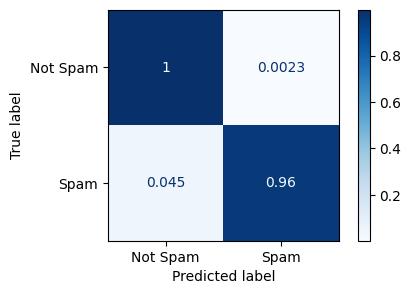

In [58]:
model_tracking("Logistic Regression", X_train, y_train, X_val, y_val, X_test, y_test)

Training Random Forest Classifier model
Training Score: 0.998254037538193
Validation Score: 0.9876543209876543
Running: Random Forest Classifier
Score on test set:
AUCPR score: 0.9695259609773961
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       439
           1       0.96      0.98      0.97       134

    accuracy                           0.98       573
   macro avg       0.97      0.98      0.98       573
weighted avg       0.98      0.98      0.98       573



2024/02/22 22:52:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest Classifier, version 1


A new version of Random Forest Classifier model.


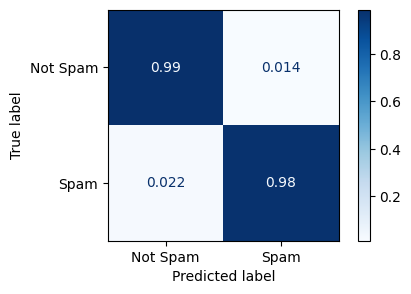

In [59]:
model_tracking("Random Forest Classifier", X_train, y_train, X_val, y_val, X_test, y_test)

Training Support Vector Classifier model
Training Score: 0.9995635093845482
Validation Score: 0.9947089947089947
Running: Support Vector Classifier
Score on test set:
AUCPR score: 0.9876358924084954
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       439
           1       0.99      0.98      0.98       134

    accuracy                           0.99       573
   macro avg       0.99      0.99      0.99       573
weighted avg       0.99      0.99      0.99       573



2024/02/22 22:52:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Support Vector Classifier, version 1


A new version of Support Vector Classifier model.


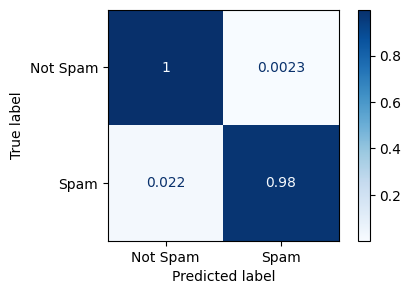

In [60]:
model_tracking("Support Vector Classifier", X_train, y_train, X_val, y_val, X_test, y_test)

Training Logistic Regression model
Training Score: 0.9960715844609341
Validation Score: 0.9876543209876543
Running: Logistic Regression
Score on test set:
AUCPR score: 0.9789715734005002
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       439
           1       0.99      0.96      0.97       134

    accuracy                           0.99       573
   macro avg       0.99      0.98      0.98       573
weighted avg       0.99      0.99      0.99       573



2024/02/22 22:54:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression, version 2


Logistic Regression model already registered.
A new version of Logistic Regression model.


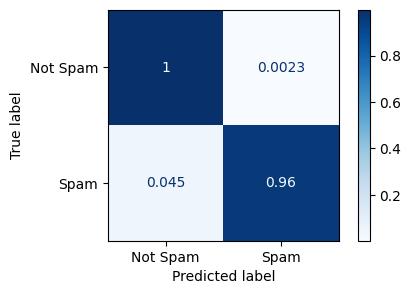

In [61]:
## another version of Logistic Regression model
model_tracking("Logistic Regression", X_train, y_train, X_val, y_val, X_test, y_test)